In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
df = pd.read_excel('D:/documents/1_projects/kombarov/input/input_2.xlsx')

df = df.rename(columns={
    # 'Накопленная добыча жидкости':'накопленная_добыча_жидкости',
    # 'Накопленная добыча нефти':'накопленная_добыча_нефти',
    # 'Накопленная добыча воды':'накопленная_добыча_воды',
    # 'Годовая добыча жидкости':'годовая_добыча_жидкости',
    # 'Годовая добыча нефти':'годовая_добыча_нефти',
    # 'Годовая добыча воды':'годовая_добыча_воды'
    'Накопленная добыча жидкости':'q_ж',
    'Накопленная добыча нефти':'q_н',
    'Накопленная добыча воды':'q_в',
    'Годовая добыча жидкости':'d_q_ж',
    'Годовая добыча нефти':'d_q_н',
    'Годовая добыча воды':'d_q_в'
})

Перевод единиц в м3

In [17]:
# исходные параметры
# ro_n_pov = 0.84
# ro_v_pov = 1.19
# q_geol = 8958.4
# q_izvl = 5491.47
# ob_koef = 1.202
ro_n_pov = 0.875
ro_v_pov = 1.12
q_geol = 18333
q_izvl = 6813
ob_koef = 1.08

# перевод тыс тонн в метры кубические, умножаем на 1000 и делим на плотность
for line in df.index:
    df.loc[line, 'q_н'] = round(df.loc[line, 'q_н'] * 1000 / ro_n_pov * ob_koef, 3)
    df.loc[line, 'd_q_н'] = round(df.loc[line, 'd_q_н'] * 1000 / ro_n_pov * ob_koef, 3)
    
    df.loc[line, 'q_в'] = round(df.loc[line, 'q_в'] * 1000 / ro_v_pov, 3)
    df.loc[line, 'd_q_в'] = round(df.loc[line, 'd_q_в'] * 1000 / ro_v_pov, 3)
    
    df.loc[line, 'q_ж'] = round(df.loc[line, 'q_в'] + df.loc[line, 'q_н'], 3)
    df.loc[line, 'd_q_ж'] = round(df.loc[line, 'd_q_в'] + df.loc[line, 'd_q_н'], 3)
    
    

# для геологических и извлекаемых запасов
q_geol = round(q_geol * 1000 / ro_n_pov * ob_koef, 3)
q_izvl = round(q_izvl * 1000 / ro_n_pov * ob_koef, 3)


In [18]:
df.head()

,год,q_ж,q_н,q_в,d_q_ж,d_q_н,d_q_в
0,2019,2.492844e+07,9007817.143,1.592062e+07,1021351.714,133673.143,887678.571
1,2020,2.572681e+07,9107794.286,1.661902e+07,798370.000,99977.143,698392.857
2,2021,2.669777e+07,9273929.143,1.742384e+07,970956.286,166134.857,804821.429
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Начальные извлекаемые запасы нефти численно равны коэффициенту a:

In [19]:
a = ((df.loc[2, 'q_н'] * df.loc[2, 'q_ж']) + (df.loc[1, 'q_н'] * df.loc[1, 'q_ж']) - 2 * (df.loc[0, 'q_н'] * df.loc[0, 'q_ж']))/\
    (df.loc[2, 'q_ж'] + df.loc[1, 'q_ж'] - 2 * df.loc[0, 'q_ж'])
b = a * df.loc[2, 'q_ж'] - (df.loc[2, 'q_н'] * df.loc[2, 'q_ж'])
print('a= ', a)
print('b= ', b)

a=  12776444.212133432
b=  93509336234807.34


In [20]:
tau_ж = df.loc[2, 'd_q_ж'] / q_izvl * 100

df['B'] = 0
df['B_ves'] = 0
df['tau_н'] = 0
df['КИН_тек'] = 0


for line in range(3, 100):
    # 2.Определяем годовую добычу нефти
    df.loc[line, 'd_q_н'] = a - (b / (df.loc[2, 'q_ж'] + df.loc[2, 'd_q_ж'] * (line - 2))) - df.loc[line - 1, 'q_н']
    
    # Определяем добычу попутной воды по годам прогнозного периода
    df.loc[line, 'd_q_в'] = df.loc[2, 'd_q_ж'] - df.loc[line, 'd_q_н']
    
    # 4. Определяем среднегодовую объемную обводнённость добываемой жидкости, %
    df.loc[line, 'B'] = df.loc[line, 'd_q_в'] / df.loc[2, 'd_q_ж'] * 100
    
    # 5. Рассчитываются накопленные отборы нефти, воды и жидкости в пластовых
# условиях по годам прогнозируемого периода
    df.loc[line, 'q_н'] = df.loc[line - 1, 'q_н'] + df.loc[line, 'd_q_н']
    df.loc[line, 'q_в'] = df.loc[line - 1, 'q_в'] + df.loc[line, 'd_q_в']
    
    df.loc[line, 'd_q_ж'] = df.loc[line - 1, 'd_q_ж'] + df.loc[2, 'd_q_ж']
    df.loc[line, 'q_ж'] = df.loc[line - 1, 'q_ж'] + df.loc[line, 'd_q_ж']
    
    # год 
    df.loc[line, 'год'] = df.loc[line - 1, 'год'] + 1
    
    # 6. Рассчитывается весовая обводненность аналогично пункту 4,
    df.loc[line, 'B_ves'] = (df.loc[line, 'd_q_в'] * ro_v_pov) / (df.loc[2, 'd_q_в'] * ro_v_pov + df.loc[2, 'd_q_н'] * ro_n_pov) * 100
    
    # Рассчитываются годовые темпы отбора нефти и жидкости от начальных
# извлекаемых запасов нефти в пластовых условиях по годам
    df.loc[line, 'tau_н'] = df.loc[line, 'd_q_н'] / q_izvl * 100
    
    # 8. Определяем коэффициент текущего нефтеизвлечения по годам прогнозного
# периода (доли единиц):
    df.loc[line, 'КИН_тек'] = df.loc[line, 'q_н'] / q_geol
    
    if df.loc[line, 'B_ves'] > 98:
        break

In [30]:
df_result = df[3:].reset_index().drop(columns=('index'))
df_result['tau_ж'] = tau_ж

In [32]:
df_result = df_result[['d_q_н', 'd_q_в', 'd_q_ж', 'B_ves', 'q_н', 'q_в', 'q_ж', 'tau_ж', 'tau_н', 'КИН_тек']]

In [34]:
# перевод в тонны по нефти
df_result['d_q_н'] = df_result['d_q_н'].apply(lambda x: x * ro_n_pov)
df_result['q_н'] = df_result['q_н'].apply(lambda x: x * ro_n_pov)

# перевод в тонны по воде
df_result['d_q_в'] = df_result['d_q_в'].apply(lambda x: x * ro_v_pov)
df_result['q_в'] = df_result['q_в'].apply(lambda x: x * ro_v_pov)

# жидкость
df_result['d_q_ж'] = df_result['d_q_н'] + df_result['d_q_в']
df_result['q_ж'] = df_result['q_н'] + df_result['q_в']


In [35]:
df_result

,d_q_н,d_q_в,d_q_ж,B_ves,q_н,q_в,q_ж,tau_ж,tau_н,КИН_тек
0,107547.074393,9.498108e+05,1.057358e+06,90.737469,8.222235e+06,2.046451e+07,2.868675e+07,11.546373,1.461627,0.415272
1,100254.848763,9.591448e+05,1.059400e+06,91.629170,8.322490e+06,2.142366e+07,2.974615e+07,11.546373,1.362521,0.420335
2,93679.976722,9.675607e+05,1.061241e+06,92.433153,8.416170e+06,2.239122e+07,3.080739e+07,11.546373,1.273165,0.425067
3,87731.355238,9.751749e+05,1.062906e+06,93.160558,8.503901e+06,2.336639e+07,3.187029e+07,11.546373,1.192320,0.429498
4,82331.898697,9.820862e+05,1.064418e+06,93.820809,8.586233e+06,2.434848e+07,3.293471e+07,11.546373,1.118938,0.433656
5,77416.028052,9.883785e+05,1.065795e+06,94.421928,8.663649e+06,2.533686e+07,3.400051e+07,11.546373,1.052128,0.437566
6,72927.669462,9.941236e+05,1.067051e+06,94.970769,8.736577e+06,2.633098e+07,3.506756e+07,11.546373,0.991129,0.441249
7,68818.647624,9.993832e+05,1.068202e+06,95.473225,8.805395e+06,2.733036e+07,3.613576e+07,11.546373,0.935285,0.444725
8,65047.387245,1.004210e+06,1.069258e+06,95.934379,8.870443e+06,2.833457e+07,3.720502e+07,11.546373,0.884031,0.448010
9,61577.856945,1.008651e+06,1.070229e+06,96.358638,8.932021e+06,2.934322e+07,3.827525e+07,11.546373,0.836879,0.451120


Text(0, 0.5, 'Тонн/год')

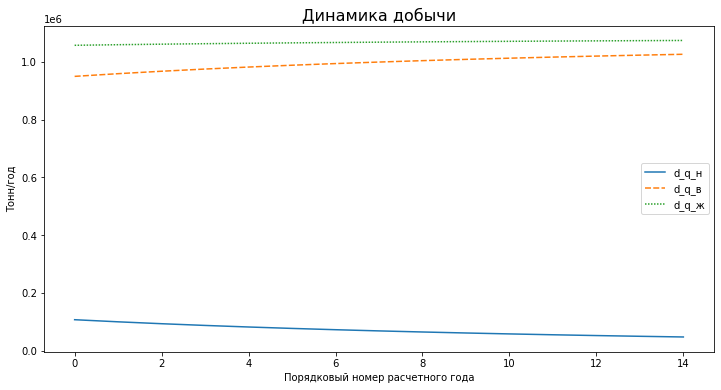

In [40]:
fig = plt.figure(figsize=(12, 6))
lineplot = sns.lineplot(data=df_result[['d_q_н', 'd_q_в', 'd_q_ж']])
lineplot.set_title('Динамика добычи', fontsize=16)
lineplot.set_xlabel('Порядковый номер расчетного года')
lineplot.set_ylabel('Тонн/год')

Text(0, 0.5, 'Тонн/год')

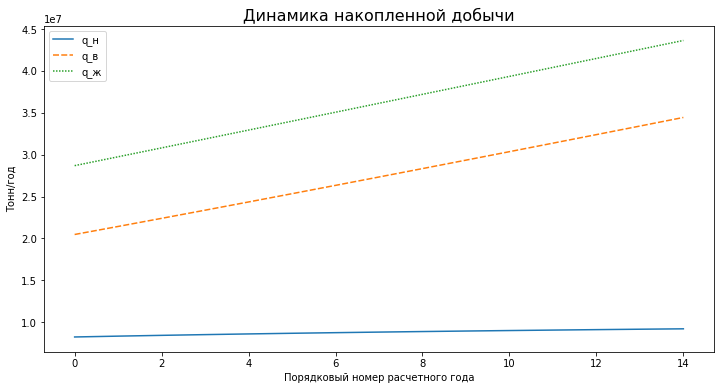

In [41]:
fig = plt.figure(figsize=(12, 6))
lineplot = sns.lineplot(data=df_result[['q_н', 'q_в', 'q_ж']])
lineplot.set_title('Динамика накопленной добычи', fontsize=16)
lineplot.set_xlabel('Порядковый номер расчетного года')
lineplot.set_ylabel('Тонн/год')

In [36]:
df_result.to_excel('D:/documents/1_projects/kombarov/result/result_komb.xlsx', sheet_name='main')